# Inkar einlesen

by Matthias Dorner

### Setup

In [1]:
# Optional 
#%pip install "pandas>=2.1,<2.3" "pyarrow>=14,<18" "py7zr"

In [2]:
# Imports 
import pandas as pd
from pathlib import Path
import pyarrow
from typing import Iterable, Optional, Tuple, Union
from pathlib import Path
import urllib.request
import py7zr
from pathlib import Path
import urllib.request
import zipfile
import shutil
import subprocess

In [3]:
# Paths for input and output files
inkar_path = Path(r"data\inkar_2025.csv")
out_path_parquet = inkar_path.with_name("inkar_bayern_nordbayern.parquet")
out_path_csv = inkar_path.with_name("inkar_bayern_nordbayern.csv")

### Definitionen 

In [4]:
# Filter Raumbezug values
#valid_raumbezug = ["Gemeinden", "Gemeindeverbände (Verwaltungsgemeinschaft)","Kreise", "Regierungsbezirke", "Bundesländer"] # Extended list for Gemeinden 
valid_raumbezug = ["Kreise", "Regierungsbezirke", "Bundesländer"]

# Filter Regierungsbezirke in Nordbayern: Oberpfalz, Oberfranken, Unterfranken, Mittelfranken
regierungsbezirke_kennziffern = ["093", "094", "095", "096"]

### Download & Extraktion (wichtig: nur einmal ausführen, vorher 7Zip installieren)

In [5]:
# Paths & URL
download_url = "https://www.bbr-server.de/imagemap/inkar/download/inkar_2025.zip"
extract_folder = Path("data/inkar")
zip_file_path = extract_folder / "inkar_2025.zip"
csv_file_path = extract_folder / "inkar_2025.csv"

extract_folder.mkdir(parents=True, exist_ok=True)


# 1) Exit early if CSV already exists
if csv_file_path.exists():
    print(f"CSV already exists → nothing to do:\n  {csv_file_path}")
    inkar_path = csv_file_path

else:
    # 2) Download ZIP only if missing
    if zip_file_path.exists():
        print(f"ZIP already exists → skipping download:\n  {zip_file_path}")
    else:
        print(f"Downloading {download_url}...")
        urllib.request.urlretrieve(download_url, zip_file_path)

    # 3) Try built-in zipfile first
    extracted = False
    try:
        print("Trying built-in zipfile extraction...")
        with zipfile.ZipFile(zip_file_path, "r") as zf:
            zf.extractall(extract_folder)
        extracted = True
    except Exception as e:
        print(f"Built-in extraction failed ({type(e).__name__}: {e})")

    # 4) Fallback to 7-Zip if needed
    if not extracted:
        print("Falling back to 7-Zip extraction...")

        seven_zip = (
            shutil.which("7z")
            or shutil.which("7za")
            or (r"C:\Program Files\7-Zip\7z.exe" if Path(r"C:\Program Files\7-Zip\7z.exe").exists() else None)
        )

        if not seven_zip:
            raise RuntimeError(
                "ZIP uses LZMA compression but Python lacks lzma support.\n"
                "Install 7-Zip or reinstall Python from python.org."
            )

        subprocess.run(
            [seven_zip, "x", str(zip_file_path), f"-o{extract_folder}", "-y"],
            check=True
        )

    # 5) Resolve CSV robustly
    csv_candidates = list(extract_folder.rglob("*.csv"))
    if not csv_candidates:
        raise FileNotFoundError("No CSV file found after extraction.")

    # prefer exact match, fallback to first CSV
    inkar_path = (
        csv_file_path
        if csv_file_path.exists()
        else next((p for p in csv_candidates if "inkar" in p.name.lower()), csv_candidates[0])
    )

    print(f"CSV extracted to:\n  {inkar_path}")

# Final path
print(f"Inkar file ready at:\n  {inkar_path}")


Trying built-in zipfile extraction...
Built-in extraction failed (NotImplementedError: That compression method is not supported)
Falling back to 7-Zip extraction...
CSV extracted to:
  data\inkar\inkar_2025.csv
Inkar file ready at:
  data\inkar\inkar_2025.csv


### Einlesen in chunks für große Dateien

In [6]:
# Load Inkar data in chunks
chunksize = 500_000

chunks = []
for chunk in pd.read_csv(
    inkar_path,
    sep=";",
    chunksize=chunksize,
    dtype={"Kennziffer":"string","Zeitbezug":"string","Wert":"string","Raumbezug":"string","ID":"string"},
):
    # Filter Kreise in Bavaria (= Kennziffer "09xxxx")
    chunk = chunk[chunk["Kennziffer"].str.startswith("09", na=False)] 
    
    # Filter on valid list of Raumbezug
    chunk = chunk[chunk["Raumbezug"].isin(valid_raumbezug)]

    # Replace commas with dots in "Wert" column and convert to numeric
    chunk["Wert"] = pd.to_numeric(chunk["Wert"].str.replace(",", "."), errors="coerce")
    
    if chunk.empty:
        continue

    chunks.append(chunk)

inkar_df = pd.concat(chunks, ignore_index=True)

# Create a new column "Nordbayern" to indicate if the row is in Nordbayern
inkar_df['Nordbayern'] = inkar_df['Kennziffer'].str.startswith(tuple(regierungsbezirke_kennziffern), na=False)

# Order columns appropriately
inkar_df = inkar_df[["Kennziffer", "Name", "Nordbayern", "Raumbezug", "Zeitbezug", "Indikator", "Kuerzel", "Bereich", "ID", "Wert"]]

### Datenbeschreibung

In [7]:
# Print basic info
print(f"DataFrame shape: {inkar_df.shape}")

# Print schema info
print("\nDataFrame info:")
print(inkar_df.info())

# Print first few rows
print("\nDataFrame head:")
inkar_df.head(10)

DataFrame shape: (850220, 10)

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850220 entries, 0 to 850219
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Kennziffer  850220 non-null  string 
 1   Name        850220 non-null  object 
 2   Nordbayern  850220 non-null  boolean
 3   Raumbezug   850220 non-null  string 
 4   Zeitbezug   850220 non-null  string 
 5   Indikator   850124 non-null  object 
 6   Kuerzel     850220 non-null  object 
 7   Bereich     850028 non-null  object 
 8   ID          844940 non-null  string 
 9   Wert        850220 non-null  Float64
dtypes: Float64(1), boolean(1), object(4), string(4)
memory usage: 60.8+ MB
None

DataFrame head:


,Kennziffer,Name,Nordbayern,Raumbezug,Zeitbezug,Indikator,Kuerzel,Bereich,ID,Wert
0,09161000,Ingolstadt,False,Kreise,2023,Bevölkerung,a_bb_4G,EU,<NA>,100.0
1,09161000,Ingolstadt,False,Kreise,2023,Bildung,a_bb_4G,EU,<NA>,100.0
2,09161000,Ingolstadt,False,Kreise,2023,Gesundheit,a_bb_4G,EU,<NA>,100.0
3,09161000,Ingolstadt,False,Kreise,2023,Siedlungsstruktur,a_bb_4G,EU,<NA>,100.0
4,09161000,Ingolstadt,False,Kreise,2023,Verkehr,a_bb_4G,EU,<NA>,100.0
5,09161000,Ingolstadt,False,Kreise,2023,Wirtschaft,a_bb_4G,EU,<NA>,100.0
6,09162000,"München, Landeshauptstadt",False,Kreise,2023,Bevölkerung,a_bb_4G,EU,<NA>,100.0
7,09162000,"München, Landeshauptstadt",False,Kreise,2023,Bildung,a_bb_4G,EU,<NA>,100.0
8,09162000,"München, Landeshauptstadt",False,Kreise,2023,Gesundheit,a_bb_4G,EU,<NA>,100.0
9,09162000,"München, Landeshauptstadt",False,Kreise,2023,Siedlungsstruktur,a_bb_4G,EU,<NA>,100.0


In [8]:
# Unique values in Raumbezug
print("\nUnique values in 'Raumbezug':")
print(inkar_df["Raumbezug"].unique())

# Unique values in Zeitbezug
print("\nUnique values in 'Zeitbezug':")
print(inkar_df["Zeitbezug"].unique())

# Unique values of tuples Indikator and Kuerzel
print("\nUnique values in 'Indikator' and 'Kuerzel':")
inkar_df[["Indikator", "Kuerzel"]].dropna().drop_duplicates(subset=["Kuerzel", "Indikator"]).sort_values(by=["Indikator"]).reset_index(drop=True)


Unique values in 'Raumbezug':
<StringArray>
['Kreise', 'Bundesländer', 'Regierungsbezirke']
Length: 3, dtype: string

Unique values in 'Zeitbezug':
<StringArray>
['2023', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002',
 '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011',
 '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
 '2021', '2022', '2024', '2025']
Length: 31, dtype: string

Unique values in 'Indikator' and 'Kuerzel':


,Indikator,Kuerzel
0,(SDG 1) Armut - Altersarmut,a_GSa
1,(SDG 1) Armut - Kinderarmut,q_newfBGu15_bev
2,(SDG 1) SGB II-/SGB XII-Quote,a_sgbII_III_bev
3,(SDG 10) Beschäftigungsquote - Ausländer,q_svw_ausl
4,(SDG 10) Einbürgerungen,q_ebuerg_aus
...,...,...
591,ÖV-Haltestellen,Haltestelle insgesamt
592,Öffentliche Bibliotheken,BibOEB
593,Öffentliche Bäder,OeffBad
594,Öffentliche Finanzen,a_bb_4G


### Speichern

In [9]:
# Save panel_long_ordered to parquet
inkar_df.to_parquet(out_path_parquet, engine="pyarrow", compression="zstd", index=False)

# Export as csv for compatibility
inkar_df.to_csv(out_path_csv, index=False)

del inkar_df  # Free memory

# Parquet File einlesen 

In [10]:
# Read back parquet to verify
inkar_df = pd.read_parquet(out_path_parquet, engine="pyarrow")

### Filter Nordbayern und Bayern (falls nötig)

In [11]:
# Filtere auf Zeilen mit Raumbezug = Bundesländer oder Nordbayern = True
inkar_df = inkar_df[(inkar_df["Raumbezug"] == "Bundesländer") | (inkar_df["Nordbayern"] == True)]

### Function for pivoting (if needed)

In [12]:
YearList = Iterable[Union[int, str]]
YearRange = Tuple[Union[int, str], Union[int, str]]
TimeFilter = Union[YearList, YearRange, range]

def filter_and_pivot_inkar(
    df: pd.DataFrame,
    raumbezug: str,
    indikatoren: list[str],
    time_filter: Optional[TimeFilter] = None,
) -> pd.DataFrame:
    """
    Filters by Raumbezug and Indikator, optionally filters Zeitbezug by either:
      - list/iterable of years (e.g., [2018, 2019, 2020])
      - range tuple inclusive (e.g., (2018, 2022))
      - Python range (e.g., range(2018, 2023))
    Then pivots to columns: {Zeitbezug}_{Indikator}.
    """

    # --- basic filters ---
    df_filtered = df[df["Raumbezug"] == raumbezug].copy()
    df_filtered = df_filtered[df_filtered["Indikator"].isin(indikatoren)].copy()

    # --- Zeitbezug normalization (robust to str/int) ---
    # Convert to integer year where possible; keep original for final column naming
    z_raw = df_filtered["Zeitbezug"]
    z_year = pd.to_numeric(z_raw, errors="coerce").astype("Int64")  # nullable int

    # --- time filter ---
    if time_filter is not None:
        if isinstance(time_filter, tuple) and len(time_filter) == 2:
            start, end = time_filter
            start_i = int(pd.to_numeric(start, errors="raise"))
            end_i = int(pd.to_numeric(end, errors="raise"))
            df_filtered = df_filtered[(z_year >= start_i) & (z_year <= end_i)].copy()
        else:
            # list / iterable / range
            years = [int(pd.to_numeric(y, errors="raise")) for y in list(time_filter)]
            df_filtered = df_filtered[z_year.isin(years)].copy()

    # Optional: ensure Zeitbezug used in columns is clean (string version of numeric year if available)
    df_filtered["Zeitbezug"] = pd.to_numeric(df_filtered["Zeitbezug"], errors="coerce") \
                                .astype("Int64") \
                                .astype(str) \
                                .where(pd.to_numeric(df_filtered["Zeitbezug"], errors="coerce").notna(),
                                       df_filtered["Zeitbezug"].astype(str))

    # --- pivot ---
    df_pivoted = df_filtered.pivot_table(
        index=["Kennziffer", "Name", "Nordbayern"],
        columns=["Zeitbezug", "Indikator"],
        values="Wert",
        aggfunc="first"  # change if you expect duplicates and want mean/sum/etc.
    )

    # flatten columns
    df_pivoted.columns = [f"{zeitbezug}_{indikator}" for zeitbezug, indikator in df_pivoted.columns]
    df_pivoted = df_pivoted.reset_index()

    return df_pivoted


### Check function for pivoting (if needed)

In [13]:
# Test for selected indicators and time filters
indikatoren_liste = ["Angebotsmietpreise", "Arbeitslosenquote"]

# List of years 
test1 = filter_and_pivot_inkar(inkar_df, "Kreise", indikatoren_liste, time_filter=[2018, 2020, 2022])

# 2) Inclusive range
test2 = filter_and_pivot_inkar(inkar_df, "Kreise", indikatoren_liste, time_filter=(2015, 2022))

# 3) Range of years
test3 = filter_and_pivot_inkar(inkar_df, "Kreise", indikatoren_liste, time_filter=range(2020, 2023))

In [14]:
test3

,Kennziffer,Name,Nordbayern,2020_Angebotsmietpreise,2020_Arbeitslosenquote,2021_Angebotsmietpreise,2021_Arbeitslosenquote,2022_Angebotsmietpreise,2022_Arbeitslosenquote
0,09361000,Amberg,True,8.0,5.35,8.0,4.68,9.0,4.22
1,09362000,"Regensburg, Stadt",True,11.0,4.38,11.0,4.32,12.0,3.81
2,09363000,Weiden i.d.OPf.,True,7.0,5.73,7.0,5.12,8.0,4.69
3,09371000,Amberg-Sulzbach,True,7.0,2.92,7.0,2.73,8.0,2.59
4,09372000,Cham,True,6.0,3.16,7.0,2.85,7.0,2.73
5,09373000,Neumarkt i.d.OPf.,True,8.0,2.22,9.0,2.13,9.0,1.97
6,09374000,Neustadt a.d.Waldnaab,True,6.0,3.31,7.0,3.04,7.0,2.94
7,09375000,Regensburg,True,9.0,2.6,8.0,2.61,9.0,2.36
8,09376000,Schwandorf,True,7.0,3.42,8.0,3.08,8.0,2.86
9,09377000,Tirschenreuth,True,5.0,3.36,6.0,3.1,6.0,3.28


### Clean panel data 

In [15]:
# Create function to clean up panel data inkar_df for time series plotting and analysis. cleaning should include generation of a balanced panel with columns for each indicator and time period. and filtering on a selected raumbezug category and list of indikatoren. No pivoting should be done here, just cleaning and filtering.

def clean_inkar_panel(df, raumbezug, indikatoren, time_filter=None):
    """
    Filters by Raumbezug and Indikator, optionally filters Zeitbezug by either:
      - list/iterable of years (e.g., [2018, 2019, 2020])
      - range tuple inclusive (e.g., (2018, 2022))
      - Python range (e.g., range(2018, 2023))
    """

    # --- basic filters ---
    df_filtered = df[df["Raumbezug"] == raumbezug].copy()
    df_filtered = df_filtered[df_filtered["Indikator"].isin(indikatoren)].copy()

    # --- Zeitbezug normalization (robust to str/int) ---
    # Convert to integer year where possible; keep original for final column naming
    z_raw = df_filtered["Zeitbezug"]
    z_year = pd.to_numeric(z_raw, errors="coerce").astype("Int64")  # nullable int

    # --- time filter ---
    if time_filter is not None:
        if isinstance(time_filter, tuple) and len(time_filter) == 2:
            start, end = time_filter
            start_i = int(pd.to_numeric(start, errors="raise"))
            end_i = int(pd.to_numeric(end, errors="raise"))
            df_filtered = df_filtered[(z_year >= start_i) & (z_year <= end_i)].copy()
        else:
            # list / iterable / range
            years = [int(pd.to_numeric(y, errors="raise")) for y in list(time_filter)]
            df_filtered = df_filtered[z_year.isin(years)].copy()

    return df_filtered

In [16]:
# Example 
cleaned_df = clean_inkar_panel(inkar_df, "Kreise", indikatoren_liste, time_filter=(2015, 2022))
cleaned_df

,Kennziffer,Name,Nordbayern,Raumbezug,Zeitbezug,Indikator,Kuerzel,Bereich,ID,Wert
92831,09361000,Amberg,True,Kreise,2015,Arbeitslosenquote,q_alo,LRB,14574,5.63
92832,09361000,Amberg,True,Kreise,2016,Arbeitslosenquote,q_alo,LRB,14574,5.89
92833,09361000,Amberg,True,Kreise,2017,Arbeitslosenquote,q_alo,LRB,14574,5.29
92834,09361000,Amberg,True,Kreise,2018,Arbeitslosenquote,q_alo,LRB,14574,4.4
92835,09361000,Amberg,True,Kreise,2019,Arbeitslosenquote,q_alo,LRB,14574,4.23
...,...,...,...,...,...,...,...,...,...,...
721780,09679000,Würzburg,True,Kreise,2018,Angebotsmietpreise,m_mietpr,LRB,20067,9.0
721781,09679000,Würzburg,True,Kreise,2019,Angebotsmietpreise,m_mietpr,LRB,20067,9.0
721782,09679000,Würzburg,True,Kreise,2020,Angebotsmietpreise,m_mietpr,LRB,20067,9.0
721783,09679000,Würzburg,True,Kreise,2021,Angebotsmietpreise,m_mietpr,LRB,20067,9.0


C:\Users\Matthias\AppData\Local\Temp\ipykernel_11976\2397481438.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plot = cleaned_df[


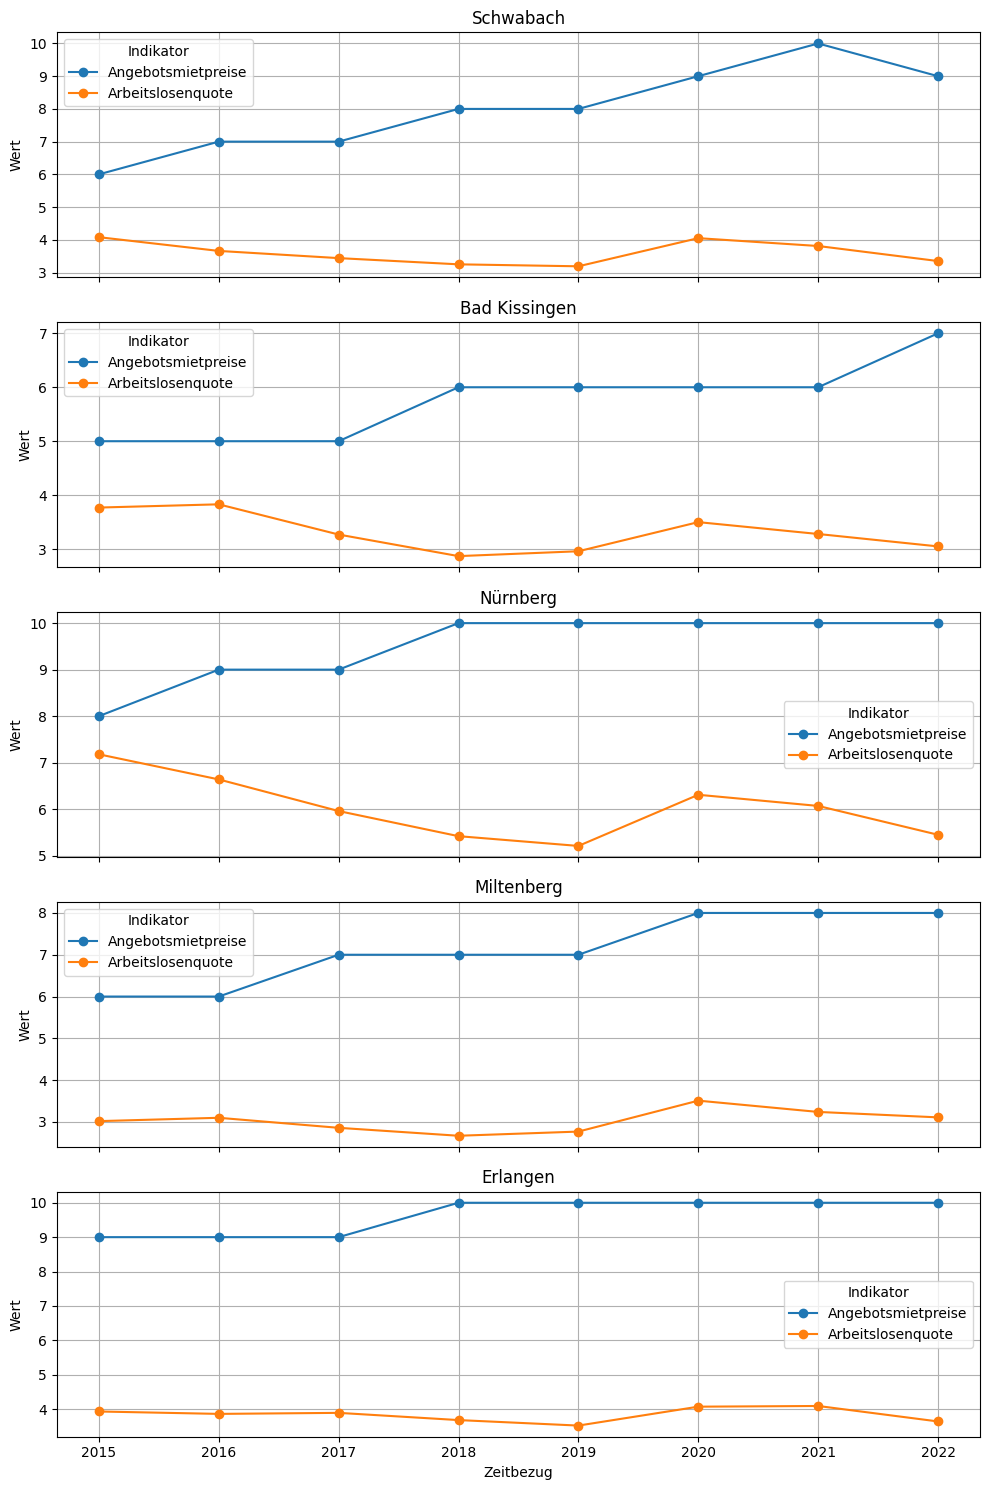

In [17]:
import matplotlib.pyplot as plt

# select up to 5 random Kreise (Names)
names_series = pd.Series(inkar_df.loc[inkar_df["Raumbezug"] == "Kreise", "Name"].dropna().unique())
n = min(5, len(names_series))
sampled_names = names_series.sample(n=n, random_state=42).tolist()

# prepare data
df_plot = cleaned_df[
    (inkar_df["Raumbezug"] == "Kreise") &
    (inkar_df["Indikator"].isin(indikatoren_liste)) &
    (inkar_df["Name"].isin(sampled_names))
].copy()

df_plot["Zeitbezug"] = pd.to_numeric(df_plot["Zeitbezug"], errors="coerce").astype("Int64")
df_plot = df_plot.dropna(subset=["Zeitbezug"])

df_pivot = df_plot.pivot_table(index=["Name", "Zeitbezug"], columns="Indikator", values="Wert").reset_index()
df_pivot = df_pivot.sort_values(["Name", "Zeitbezug"])

available_indikatoren = [i for i in indikatoren_liste if i in df_pivot.columns]
if not available_indikatoren:
    raise ValueError("None of the requested indikatoren are available in the data for selected Kreise.")

# plot using pandas plotting
fig, axes = plt.subplots(nrows=len(sampled_names), ncols=1, figsize=(10, 3 * len(sampled_names)), sharex=True)
if len(sampled_names) == 1:
    axes = [axes]

for ax, name in zip(axes, sampled_names):
    df_name = df_pivot[df_pivot["Name"] == name].set_index("Zeitbezug")[available_indikatoren]
    df_name.plot(ax=ax, marker="o")
    ax.set_title(name)
    ax.set_ylabel("Wert")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [18]:
import plotly
import plotly.graph_objects as go

# Prepare data with all indicators and kreise
df_all = cleaned_df.copy()
df_all["Zeitbezug"] = pd.to_numeric(df_all["Zeitbezug"], errors="coerce").astype("Int64")
df_all = df_all.dropna(subset=["Zeitbezug"])

# Get unique kreise and indikatoren
kreise_list = sorted(df_all["Name"].unique())
indikatoren_all = sorted(df_all["Indikator"].unique())

# Create figure with dropdowns
fig = go.Figure()

# Add traces for each combination of Kreis and Indikator
for kreis in kreise_list:
    for indikator in indikatoren_all:
        df_subset = df_all[(df_all["Name"] == kreis) & (df_all["Indikator"] == indikator)]
        df_subset = df_subset.sort_values("Zeitbezug")
        
        if not df_subset.empty:
            visible = (kreis == kreise_list[0]) and (indikator == indikatoren_all[0])
            fig.add_trace(go.Scatter(
                x=df_subset["Zeitbezug"],
                y=df_subset["Wert"],
                mode="lines+markers",
                name=f"{kreis} - {indikator}",
                visible=visible,
                hovertemplate=f"<b>{kreis}</b><br>Jahr: %{{x}}<br>{indikator}: %{{y:.2f}}<extra></extra>"
            ))

# Create dropdown buttons for Kreise
kreis_buttons = []
for kreis in kreise_list:
    visibility = [
        (trace.name.startswith(kreis)) for trace in fig.data
    ]
    kreis_buttons.append(
        dict(label=kreis, method="update", 
             args=[{"visible": visibility}, {"title": f"Indikatoren für {kreis}"}])
    )

# Create dropdown buttons for Indikatoren
indikator_buttons = []
for indikator in indikatoren_all:
    visibility = [
        (trace.name.endswith(indikator)) for trace in fig.data
    ]
    indikator_buttons.append(
        dict(label=indikator, method="update",
             args=[{"visible": visibility}, {"title": f"Zeitreihe: {indikator}"}])
    )

# Add dropdowns to layout
fig.update_layout(
    updatemenus=[
        dict(buttons=kreis_buttons, direction="down", pad={"r": 10, "t": 10},
             showactive=True, x=0.0, xanchor="left", y=1.15, yanchor="top",
             bgcolor="lightgray", bordercolor="gray", font=dict(size=11)),
        dict(buttons=indikator_buttons, direction="down", pad={"r": 10, "t": 10},
             showactive=True, x=0.3, xanchor="left", y=1.15, yanchor="top",
             bgcolor="lightgray", bordercolor="gray", font=dict(size=11))
    ],
    title=f"{kreise_list[0]} - {indikatoren_all[0]}",
    xaxis_title="Zeitbezug",
    yaxis_title="Wert",
    hovermode="x unified",
    height=600,
    margin=dict(t=150)
)

fig.show()